In [1]:
import sqlite3
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import tree
from sklearn.preprocessing import RobustScaler 
from sklearn import svm

In [2]:
connection = sqlite3.connect("museum_list.db") 
crsr = connection.cursor()
sql_command = """SELECT * FROM museum;"""
crsr.execute(sql_command)
myresult = crsr.fetchall()
x = []
y = []
for row in myresult:
    print(row)
    x.append(row[4])
    y.append(row[2])
x = np.asarray(x).reshape(-1,1)
y = np.asarray(y)

('Louvre', ' Paris', 10200000, 2018, 12532901, '1793; 226\xa0years ago\xa0(1793)', 'www.louvre.fr')
('National Museum of China', ' Beijing', 8610092, 2018, 24000000, '2003', 'en.chnmuseum.cn (in English)')
('Metropolitan Museum of Art[b]', ' New York City', 6953927, 2018, 22679948, '', '')
('Vatican Museums', ' Vatican City', 6756186, 2018, 1000, '1506\xa0(1506)', 'Official website')
('National Air and Space Museum', ' Washington, D.C.', 6200000, 2018, 9665892, '1946; 73\xa0years ago\xa0(1946) (as the National Air Museum)', 'http://www.nasm.si.edu')
('Tate Modern', ' London', 5868562, 2018, 14187146, '2000; 19\xa0years ago\xa0(2000)', 'tate.org.uk/modern')
('British Museum', ' London', 5829000, 2018, 14187146, '1753; 266\xa0years ago\xa0(1753)', 'britishmuseum.org')
('National Gallery', ' London', 5735831, 2018, 14187146, '1824; 195\xa0years ago\xa0(1824)', 'www.nationalgallery.org.uk')
('Natural History Museum', ' London', 5226000, 2018, 14187146, '1881; 138\xa0years ago\xa0(1881)', '

## Data Stats

In [3]:
print("Mean of input: ", x.mean())
print("Mean of output: ", y.mean())
print("Variance of input: ", x.var())

Mean of input:  12701781.37704918
Mean of output:  3552321.8524590163
Variance of input:  55045539245869.02


# Plot the Box plot to see the distribution and show the outliers

{'whiskers': [<matplotlib.lines.Line2D at 0x117abdd30>,
 'caps': [<matplotlib.lines.Line2D at 0x117ad9400>,
 'boxes': [<matplotlib.lines.Line2D at 0x117abd908>],
 'medians': [<matplotlib.lines.Line2D at 0x117ad9a90>],
 'fliers': [<matplotlib.lines.Line2D at 0x117ad9dd8>],
 'means': []}

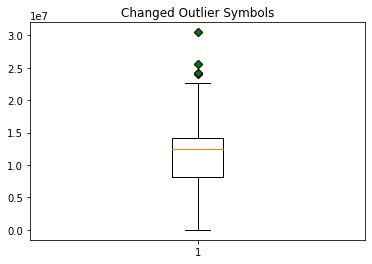

In [4]:
green_diamond = dict(markerfacecolor='g', marker='D')
fig3, ax3 = plt.subplots()
ax3.set_title('Changed Outlier Symbols')
ax3.boxplot(x, flierprops=green_diamond)

# Split the data

In [5]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print("# training examples: ",len(X_train))
print("# valid examples: ",len(X_val))
print("# test examples: ",len(X_test))

# training examples:  36
# valid examples:  12
# test examples:  13


#  Scale the data

In [6]:
transformer = RobustScaler().fit(X_train)

transformed_X_train = transformer.transform(X_train)
transformed_X_val = transformer.transform(X_val)
transformed_X_test = transformer.transform(X_test)

'''
transformed_X_train = X_train/10000
transformed_X_val = X_val/10000
transformed_X_test = X_test/10000
'''

transformed_y_train = y_train/10000
transformed_y_val = y_val/10000
transformed_y_test = y_test/10000

Before scaling..


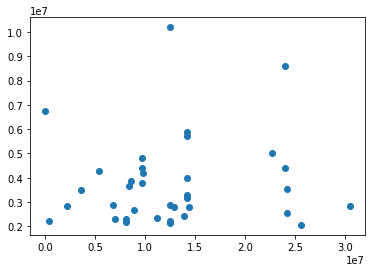

In [7]:
fig, ax = plt.subplots()
print("Before scaling..")
ax.scatter(X_train, y_train)

After scaling..


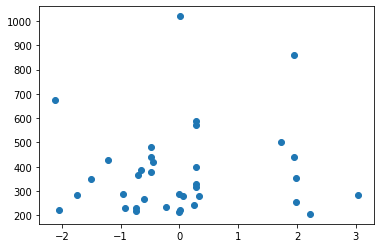

In [8]:
fig, ax = plt.subplots()
print("After scaling..")
ax.scatter(transformed_X_train, transformed_y_train)

In [9]:
def generate_poly_features(x, degree):
    features = []
    for i in range(degree):
        features.append(x**(i+1))
    
    return np.concatenate(features, axis=1)

## Regression

In [10]:
def regressor(model, X_train, y_train, X_val, y_val, X_test, y_test, step, degree):

    xmin = min(X_train)
    xmax = max(X_train)
    xx = np.arange(xmin,xmax, step).reshape(-1,1)
    fig, ax = plt.subplots()
    ax.scatter(X_train, y_train, edgecolors=(0, 0, 0))

    X_train_feats = generate_poly_features(X_train, degree)
    X_val_feats = generate_poly_features(X_val, degree)
    X_test_feats = generate_poly_features(X_test, degree)


    model.fit(X_train_feats, y_train)
    prediction_linear_train = model.predict(X_train_feats)
    prediction_linear_valid = model.predict(X_val_feats)
    
    train_error = mean_squared_error(y_train, prediction_linear_train)
    val_error = mean_squared_error(y_val, prediction_linear_valid)

    print("Mean Squared error of training data when feature x is used: ", train_error)
    print("Mean squared error of validation data when feature x is used: ", val_error)

    yy_linear = model.predict(generate_poly_features(xx, degree))

    ax.plot(xx,yy_linear)


    #ax.legend(['trained with x', 'trained with x^2', 'trained with x^3', 'trained with sqrt(x)'])


    plt.title("Linear Regression")
    plt.xlabel("Population of City")
    plt.ylabel("Number of Visitors")
    plt.show()
    return train_error, val_error




In [14]:
def model_selection(model, X_train, y_train, X_val, y_val, X_test, y_test, step):
    
    best_val = float('Inf')
    best_deg = 100
    
    for degree in range(1,10):
        if model == "linear regression":
            model = LinearRegression()
        elif model == "DT":
            model = tree.DecisionTreeRegressor()
        elif model == "SVR":
            model = svm.SVR(kernel="linear")
        tr, val = regressor(model, X_train, y_train, X_val, y_val, X_test, y_test, step, degree)
        if val < best_val:
            best_val = val
            best_deg = degree
    print("best degree: ", best_deg)
    print("best val error: ", best_val)

## Linear Regression

Mean Squared error of training data when feature x is used:  31920.933777145226
Mean squared error of validation data when feature x is used:  19559.942259028187


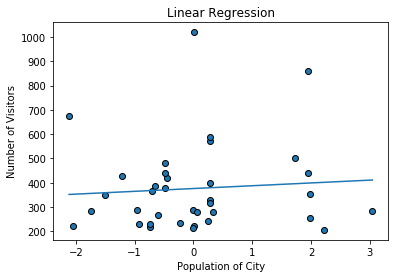

Mean Squared error of training data when feature x is used:  31907.971101831128
Mean squared error of validation data when feature x is used:  19082.243156507564


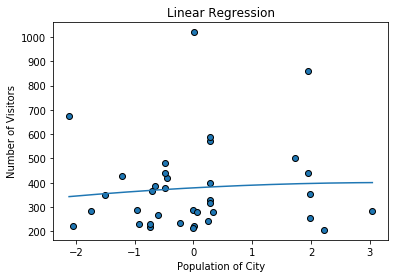

Mean Squared error of training data when feature x is used:  29820.389415411744
Mean squared error of validation data when feature x is used:  25496.38754674845


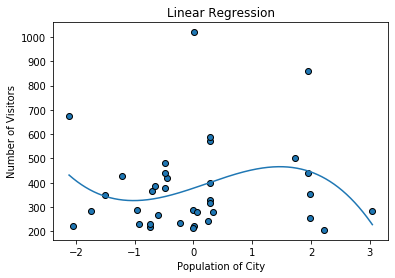

Mean Squared error of training data when feature x is used:  29594.91549098837
Mean squared error of validation data when feature x is used:  25899.623187589503


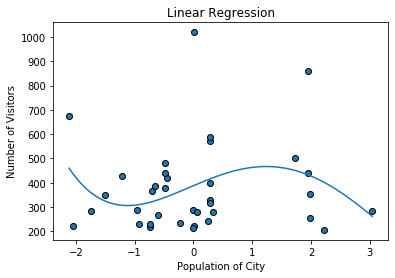

Mean Squared error of training data when feature x is used:  29593.675779060595
Mean squared error of validation data when feature x is used:  25799.61755631014


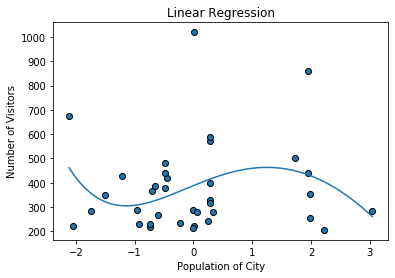

Mean Squared error of training data when feature x is used:  27874.24922206237
Mean squared error of validation data when feature x is used:  34432.185074079025


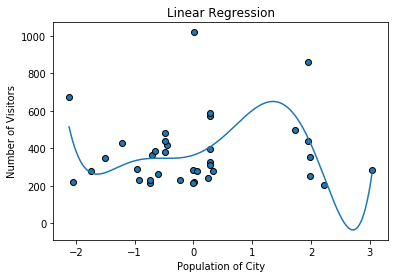

Mean Squared error of training data when feature x is used:  27807.152098514754
Mean squared error of validation data when feature x is used:  32360.383389037746


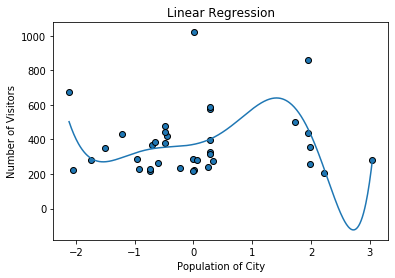

Mean Squared error of training data when feature x is used:  26084.685727298533
Mean squared error of validation data when feature x is used:  31073.759169172215


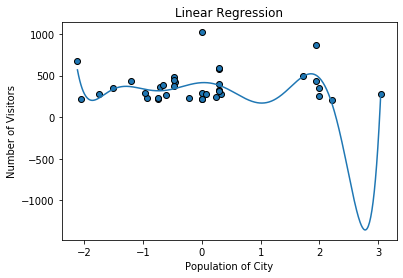

Mean Squared error of training data when feature x is used:  25313.6556304087
Mean squared error of validation data when feature x is used:  32064.41000882466


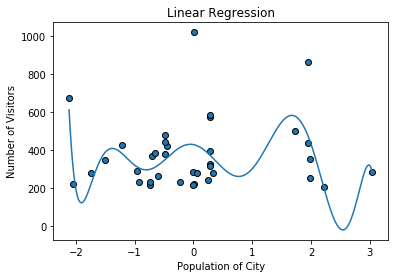

best degree:  2
best val error:  19082.243156507564


In [15]:
model_selection("linear regression", transformed_X_train, transformed_y_train,
          transformed_X_val, transformed_y_val,transformed_X_test, transformed_y_test, 0.01)

## Decision Tree Regressor

Mean Squared error of training data when feature x is used:  13563.26141714199
Mean squared error of validation data when feature x is used:  40990.2706012137


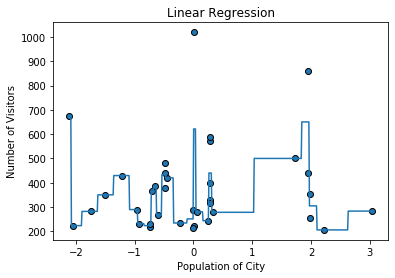

Mean Squared error of training data when feature x is used:  13563.26141714199
Mean squared error of validation data when feature x is used:  40990.2706012137


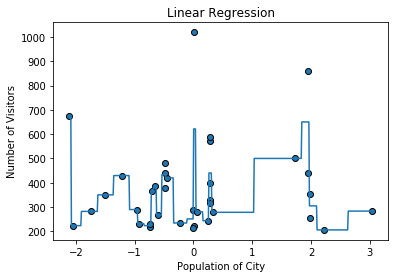

Mean Squared error of training data when feature x is used:  13563.26141714199
Mean squared error of validation data when feature x is used:  40990.2706012137


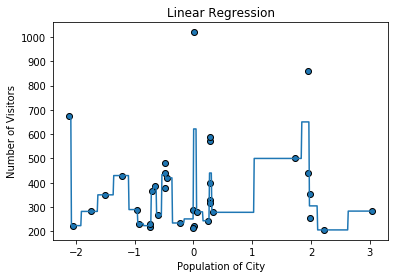

Mean Squared error of training data when feature x is used:  13563.26141714199
Mean squared error of validation data when feature x is used:  36142.933570053705


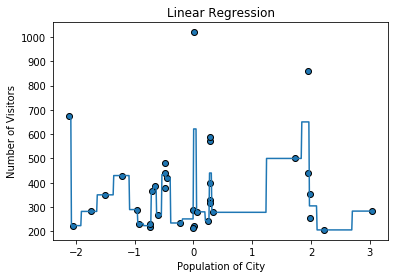

Mean Squared error of training data when feature x is used:  13563.26141714199
Mean squared error of validation data when feature x is used:  36142.933570053705


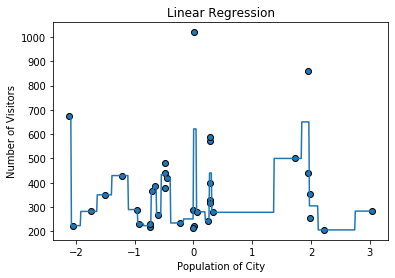

Mean Squared error of training data when feature x is used:  13563.261417141992
Mean squared error of validation data when feature x is used:  36142.933570053705


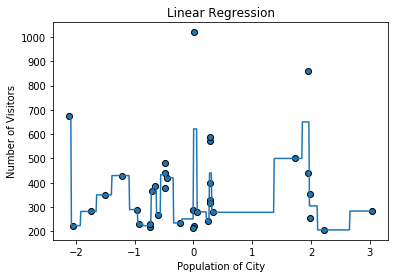

Mean Squared error of training data when feature x is used:  13563.261417141992
Mean squared error of validation data when feature x is used:  41172.72238154704


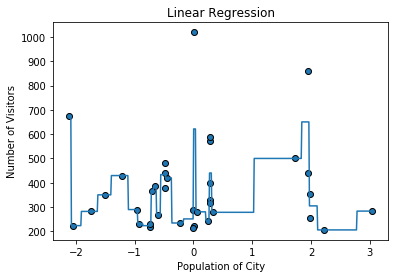

Mean Squared error of training data when feature x is used:  13563.261417141992
Mean squared error of validation data when feature x is used:  35921.270601213706


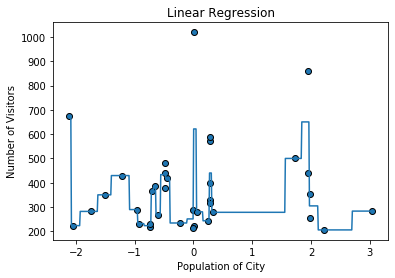

Mean Squared error of training data when feature x is used:  13563.261417141992
Mean squared error of validation data when feature x is used:  36142.933570053705


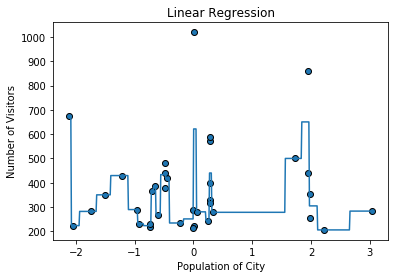

best degree:  8
best val error:  35921.270601213706


In [16]:
model_selection("DT", transformed_X_train, transformed_y_train,
          transformed_X_val, transformed_y_val,transformed_X_test, transformed_y_test, 0.01)

## Support Vector Regressor

Mean Squared error of training data when feature x is used:  35115.36513506051
Mean squared error of validation data when feature x is used:  20692.95953411854


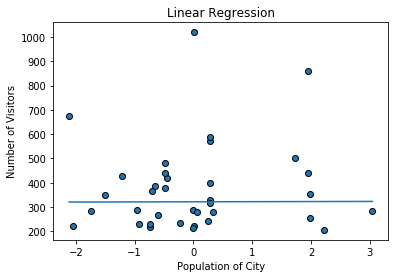

Mean Squared error of training data when feature x is used:  35607.11628468865
Mean squared error of validation data when feature x is used:  19823.957603001447


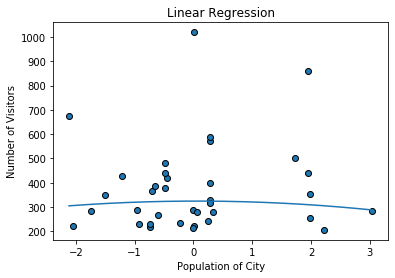

Mean Squared error of training data when feature x is used:  34357.82402256645
Mean squared error of validation data when feature x is used:  20637.565386754006


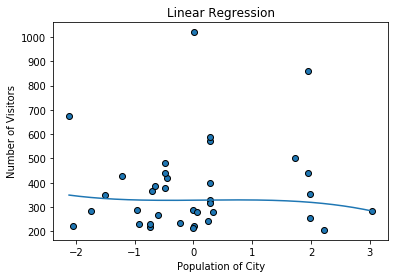

Mean Squared error of training data when feature x is used:  35524.82222709236
Mean squared error of validation data when feature x is used:  19480.64065043342


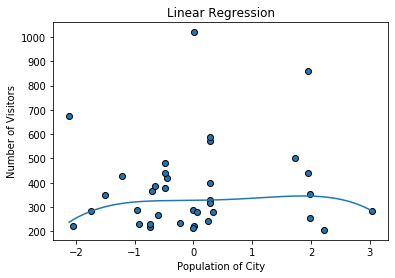

Mean Squared error of training data when feature x is used:  33332.793425644544
Mean squared error of validation data when feature x is used:  21369.186583707848


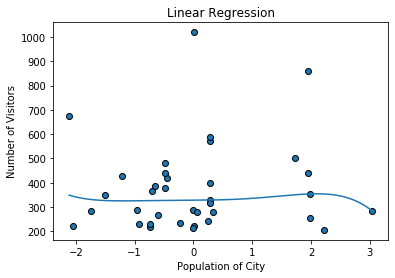

Mean Squared error of training data when feature x is used:  36218.92554372056
Mean squared error of validation data when feature x is used:  20492.655320196707


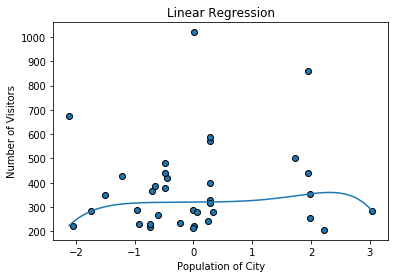

In [ ]:
model_selection("SVR", transformed_X_train, transformed_y_train,
          transformed_X_val, transformed_y_val,transformed_X_test, transformed_y_test, 0.01)